In [34]:
pip install faiss-gpu

  Using cached faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.9 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [29]:
from datasets import load_dataset
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
# from gensim.models import Word2Vec

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

GPU available


In [3]:
dataset = load_dataset('ms_marco', 'v1.1')
dataset

DatasetDict({
    validation: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 10047
    })
    train: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 82326
    })
    test: Dataset({
        features: ['answers', 'passages', 'query', 'query_id', 'query_type', 'wellFormedAnswers'],
        num_rows: 9650
    })
})

In [4]:
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

train_df = train_data.to_pandas()
train_df.drop(['query_id', 'query_type', 'wellFormedAnswers'], axis=1, inplace=True)
train_df = train_df[:100] #Using small amount of data
train_df.head()

,answers,passages,query
0,[Results-Based Accountability is a disciplined...,"{'is_selected': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]...",what is rba
1,[Yes],"{'is_selected': [0, 1, 0, 0, 0, 0, 0], 'passag...",was ronald reagan a democrat
2,[20-25 minutes],"{'is_selected': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]...",how long do you need for sydney and surroundin...
3,[$11 to $22 per square foot],"{'is_selected': [0, 0, 0, 0, 0, 0, 0, 0, 1], '...",price to install tile in shower
4,[Due to symptoms in the body],"{'is_selected': [0, 0, 1, 0, 0, 0, 0, 0], 'pas...",why conversion observed in body


In [5]:
passage = []
answer = []

for i in range(len(train_df)):
    x = train_df['answers'][i].tolist()
    if len(x)==0:
        x = "-"
    passage.append((train_df['passages'][i]['passage_text']).tolist())
    answer.append(x[0])

train_df['passages'] = passage
train_df['answers'] = answer
train_df

,answers,passages,query
0,Results-Based Accountability is a disciplined ...,"[Since 2007, the RBA's outstanding reputation ...",what is rba
1,Yes,"[In his younger years, Ronald Reagan was a mem...",was ronald reagan a democrat
2,20-25 minutes,"[Sydney, New South Wales, Australia is located...",how long do you need for sydney and surroundin...
3,$11 to $22 per square foot,"[In regards to tile installation costs, consum...",price to install tile in shower
4,Due to symptoms in the body,"[Conclusions: In adult body CT, dose to an org...",why conversion observed in body
...,...,...,...
95,WatchDog.sys is a vital system file used by th...,[WatchDog.sys was originally stored in the sys...,watchdog.sys what is
96,"In computing, .bak is a filename extension com...",[The easiest way to open a BAK file is to doub...,what is a bak file
97,"Public, four-year colleges cost $7,000 for in-...",[A: The degree that you need to be a detective...,How much will it cost to go to college to beco...
98,A document used to change one or more minor pr...,[Trust Restatement Law & Legal Definition. A r...,trust amendment term


In [6]:
# train_df = train_df.explode('passages')
# train_df = train_df.reset_index(drop = True)
train_df = train_df[['query', 'answers', 'passages']]
train_df

,query,answers,passages
0,what is rba,Results-Based Accountability is a disciplined ...,"[Since 2007, the RBA's outstanding reputation ..."
1,was ronald reagan a democrat,Yes,"[In his younger years, Ronald Reagan was a mem..."
2,how long do you need for sydney and surroundin...,20-25 minutes,"[Sydney, New South Wales, Australia is located..."
3,price to install tile in shower,$11 to $22 per square foot,"[In regards to tile installation costs, consum..."
4,why conversion observed in body,Due to symptoms in the body,"[Conclusions: In adult body CT, dose to an org..."
...,...,...,...
95,watchdog.sys what is,WatchDog.sys is a vital system file used by th...,[WatchDog.sys was originally stored in the sys...
96,what is a bak file,"In computing, .bak is a filename extension com...",[The easiest way to open a BAK file is to doub...
97,How much will it cost to go to college to beco...,"Public, four-year colleges cost $7,000 for in-...",[A: The degree that you need to be a detective...
98,trust amendment term,A document used to change one or more minor pr...,[Trust Restatement Law & Legal Definition. A r...


In [9]:
i = 65
train_df['query'][i], train_df['answers'][i], train_df['passages'][i]

('example of involuntary muscle tissue is',
 'A beating heart',
 ['Involuntary muscles are muscles that are not controllable consciously, and instead contract due to unconscious impulses sent by the autonomic nervous system or certain specialized cells or hormones. Both smooth muscle and cardiac muscle can be classified as involuntary muscles. A beating heart is one of the best examples of an involuntary muscle. Contractions of cardiac muscles push blood through the four chambers of the human heart. The process of peristalsis, which pushes food through the esophagus and small intestine, is controlled by',
  'Muscles are are classified both functionally as either voluntary or involuntary and structurally as either striated or smooth. From this, there emerges three types of muscle s: smooth involuntary (smooth) muscle, striated voluntary (skeletal) muscle and striated involuntary (cardiac) muscle. ',
  'Best Answer: voluntary muscles allow you to move them in voluntary muscles you have n

In [10]:
type(train_df['query'][i]), type(train_df['answers'][i]), type(train_df['passages'][i])

(str, str, list)

In [11]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, models
import faiss
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [20]:
# Preprocessing
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        query, answer, docs = self.data.iloc[idx]
        return query, answer, docs

# Load and preprocess data
dataset = QADataset(train_df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [38]:
# Visualizing the final inputs to the model
for i,j,k in dataloader:
    print(i)
    print(j)
    print(k)
    # print(type(k[0]))
    break

len(dataloader)

('what is rba',)
('Results-Based Accountability is a disciplined way of thinking and taking action that communities can use to improve the lives of children, youth, families, adults and the community as a whole.',)
[("Since 2007, the RBA's outstanding reputation has been affected by the 'Securency' or NPA scandal. These RBA subsidiaries were involved in bribing overseas officials so that Australia might win lucrative note-printing contracts. The assets of the bank include the gold and foreign exchange reserves of Australia, which is estimated to have a net worth of A$101 billion. Nearly 94% of the RBA's employees work at its headquarters in Sydney, New South Wales and at the Business Resumption Site.",), ("The Reserve Bank of Australia (RBA) came into being on 14 January 1960 as Australia 's central bank and banknote issuing authority, when the Reserve Bank Act 1959 removed the central banking functions from the Commonwealth Bank. The assets of the bank include the gold and foreign exc

100

In [39]:
# Testing sentence-transformers
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(len(embeddings[0])) # Creates 384 dimensional vector
embeddings[0]

384


array([ 6.76569119e-02,  6.34959191e-02,  4.87131178e-02,  7.93049634e-02,
        3.74480970e-02,  2.65278132e-03,  3.93749513e-02, -7.09846290e-03,
        5.93614243e-02,  3.15370224e-02,  6.00980818e-02, -5.29051945e-02,
        4.06067520e-02, -2.59308480e-02,  2.98428405e-02,  1.12689799e-03,
        7.35148787e-02, -5.03819138e-02, -1.22386619e-01,  2.37028636e-02,
        2.97265109e-02,  4.24768478e-02,  2.56337598e-02,  1.99518795e-03,
       -5.69190979e-02, -2.71598008e-02, -3.29035521e-02,  6.60248473e-02,
        1.19007140e-01, -4.58791070e-02, -7.26214871e-02, -3.25840041e-02,
        5.23413680e-02,  4.50552851e-02,  8.25299136e-03,  3.67023945e-02,
       -1.39415096e-02,  6.53918609e-02, -2.64272336e-02,  2.06387340e-04,
       -1.36643061e-02, -3.62810194e-02, -1.95043348e-02, -2.89738458e-02,
        3.94270308e-02, -8.84090811e-02,  2.62425840e-03,  1.36713982e-02,
        4.83063012e-02, -3.11565697e-02, -1.17329173e-01, -5.11690453e-02,
       -8.85287896e-02, -

In [34]:
# Modeling
# Initialize sentence transformer
sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

# Initialize Faiss index
dim = sentence_transformer.get_sentence_embedding_dimension()
index = faiss.IndexFlatIP(dim)

# Initialize GPT-2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

encoder = model.transformer.wte.to(device) # access the encoder (word token embeddings)
decoder = model.lm_head.to(device) # access the decoder (language model head)

In [35]:
# Define model
class QAModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(QAModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, query, docs, answer):
        # Encode query and docs
        print(f"\nquery shape is {query.shape}")
        print(f"\ndocs shape is {docs.shape}")
        print(f"\nanswer shape is {answer.shape}")

        query_emb = torch.tensor(sentence_transformer.encode(query)).to(device)
        print(f"\nquery_emb shape is {query_emb.shape}")

        doc_embs = [torch.tensor(sentence_transformer.encode(doc)).to(device) for doc in docs]
        print(f"\ndoc_embs shape is {doc_embs.shape}")

        # Retrieve top 10 documents
        top_k = 10
        scores, indices = index.search(np.vstack(doc_embs), top_k)
        top_docs = [doc_embs[idx] for idx in indices[0]]

        # Concatenate query and top docs
        input_emb = torch.cat([query_emb] + top_docs, dim=0)

        # Encode input
        encoded = self.encoder(input_emb)

        # Decode answer
        output = self.decoder(encoded, answer)

        return output

In [36]:
model = QAModel(encoder, decoder)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    for query, answer, docs in tqdm(dataloader):
        # Convert query, answer to tensors if not already (adjust based on actual data format)
        if not isinstance(query, torch.Tensor):
            query = torch.tensor(query)  # Add dtype and device as needed, e.g., dtype=torch.long, device=device
        if not isinstance(answer, torch.Tensor):
            answer = torch.tensor(answer)  # Add dtype and device as needed

        query, answer = query.to(device), answer.to(device)
        # Ensure docs is a list of tensors, adjust as necessary based on your actual data
        docs = [torch.tensor(doc).to(device) if not isinstance(doc, torch.Tensor) else doc.to(device) for doc in docs]

        optimizer.zero_grad()
        output = model(query, docs, answer)
        loss = criterion(output, answer)
        loss.backward()
        optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: too many dimensions 'str'

len of embeddings is 6
<class 'faiss.swigfaiss.IndexFlatIP'>

QUERY : 
do you have pets

TOP 3 SIMILAR DOCUMENTS:
pets are awesome
I love cats 
cats are smart 


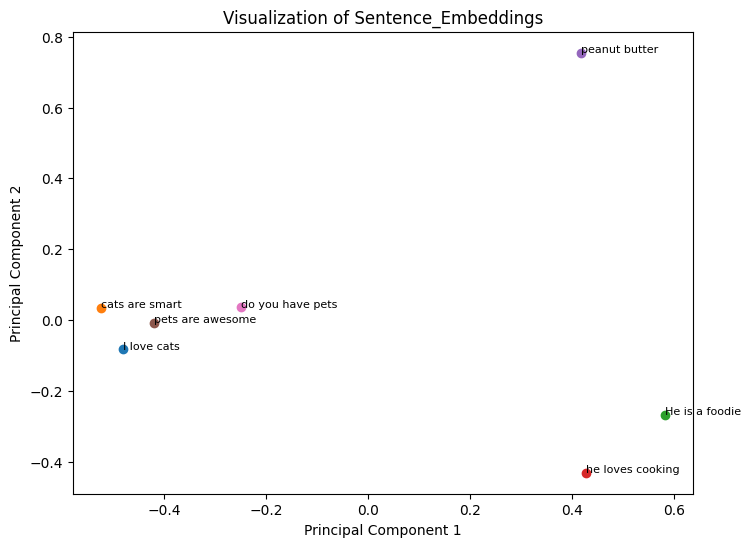

In [79]:
# Visualizing Faiss

import faiss
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load sentence transformer
sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Sample data
documents = ["I love cats ", "cats are smart ", "He is a foodie", "he loves cooking", "peanut butter", "pets are awesome"]

# Create Faiss index
dim = sentence_transformer.get_sentence_embedding_dimension()
index = faiss.IndexFlatIP(dim)

# Encode documents
embeddings = [sentence_transformer.encode(doc) for doc in documents]
print(f"len of embeddings is {len(embeddings)}")

# Add embeddings to the index
index.add(np.array(embeddings))
print(type(index))

# Query the index
query = "do you have pets"
print(f"\nQUERY : \n{query}")
query_embedding = sentence_transformer.encode(query)
top_k = 3  # Retrieve top 2 most similar documents
scores, indices = index.search(np.array([query_embedding]), top_k)

# Print the top-k most similar documents
print(f"\nTOP {top_k} SIMILAR DOCUMENTS:")
for idx in indices[0]:
    print(documents[idx])

# Retrieve the embeddings from the index
xb = []
for i in range(index.ntotal):
    xb.append(index.reconstruct(i))
xb = np.array(xb)

# Perform PCA to project to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(xb)

# Create a dictionary to map sentences to their 2D coordinates
sentence_coords = {doc: coords for doc, coords in zip(documents, embeddings_2d)}

# Add the query embedding to the dictionary
sentence_coords[query] = pca.transform(query_embedding.reshape(1, -1))[0]

# Visualize the 2D embeddings
fig, ax = plt.subplots(figsize=(8, 6))
for sentence, coords in sentence_coords.items():
    ax.scatter(coords[0], coords[1])
    ax.annotate(sentence, (coords[0], coords[1]), fontsize=8)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Visualization of Sentence_Embeddings')
plt.show()